# EDA and Cleaning for Attack Dataset

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from eda_functions import merge_with_target, split_data

## Load data

In [2]:
# *_annotated_comments dataframe
df_comments = pd.read_csv('../data/attack_annotated_comments.tsv', sep='\t')
df_comments.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
1,44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train
2,49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train
3,89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
4,93890,This page will need disambiguation.,2002,True,article,random,train


In [3]:
# *_annotations dataframe
df_annotations = pd.read_csv('../data/attack_annotations.tsv', sep='\t')
df_annotations.head()

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,1362,0.0,0.0,0.0,0.0,0.0
1,37675,2408,0.0,0.0,0.0,0.0,0.0
2,37675,1493,0.0,0.0,0.0,0.0,0.0
3,37675,1439,0.0,0.0,0.0,0.0,0.0
4,37675,170,0.0,0.0,0.0,0.0,0.0


## Preliminary exploration

### How many reviewers looked at each comment?
<br>WMF documentation said 10 reviewers per comment, but do we see this in the data?

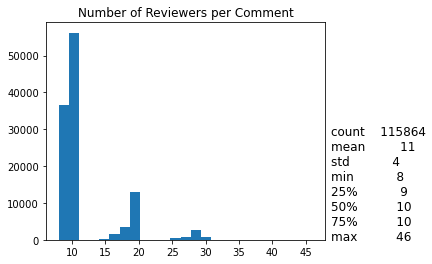

In [4]:
review_counts = df_annotations.groupby('rev_id')['attack'].count()
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(review_counts, bins=25)
ax.text(x=1.02, y=0, transform=ax.transAxes,
        s=review_counts.describe().astype(int).to_string(),
        fontsize=12);
ax.set_title('Number of Reviewers per Comment');

For the most part, each comment has 10 annotations, but there are a significant number of comments with only 8 or 9 annotations. There are also some comments with many more annotations (up to 46). 

If we had any concerns about this, it would be for annotation counts on the lower end of the spectrum (8-9). However, we feel that 8 annotations is still plenty to make a robust determination of whether a comment contains an attack.

We will not attempt to standardize the number of annotations per comment.

### Are there repeated comments?
We'd like to see if there are any duplicated comments in the dataset. If so, what are some characteristics of those comments?

In [5]:
for comment, count in df_comments['comment'].value_counts()[:10].iteritems():
    print(f'{count} occurrences of:')
    print(comment[:250] + '...' if len(comment) > 250 else comment)
    print()

10 occurrences of:
`NEWLINE_TOKEN==The Graceful Slick....==NEWLINE_TOKENIs non other than an ungraceful dick!  `

7 occurrences of:
Thank you for experimenting with  Wikipedia. Your test worked, and it has been reverted or removed. Please use the sandbox for any other tests you may want to do. Take a look at the welcome page to learn more about contributing to our encyclopedia.  ...

6 occurrences of:
`NEWLINE_TOKEN{| width=``100%`` style=``background:transparent``NEWLINE_TOKEN{| width=``100%`` style=``background-color:#F5FFFA``NEWLINE_TOKEN|style=``width: 50%; border:1px solid #084080; background-color:#F5FFFA; vertical-align:top``|NEWLINE_TOKEN{...

5 occurrences of:
NEWLINE_TOKEN* Keep.  

5 occurrences of:
NEWLINE_TOKENWelcome!NEWLINE_TOKENNEWLINE_TOKENHello, , and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Here are a few good links for newcomers:NEWLINE_TOKEN*The five pillars of WikipediaNEWLI...

5 occurrences of:
`  —Pre

**Yes, there are repeated comments,** and with the exception of the "Grateful Slick" example, they seem to be automated comments, or maybe even comments that were copy/pasted by wikipedia moderators. It's possible that we will want to remove these repeated comments, because they do not represent comments that were posted in a typical fashion by real people.

## Create target and merge into a single dataframe
Target column will be binary (1: comment contains an attack, 0: comment doesn't contain an attack). 
<br>**50% of reviewers** must label a comment as an attack for it to be categorized as such.

In [6]:
df = merge_with_target(
    df_comments=df_comments,
    df_annotations=df_annotations,
    target_col_name='attack',
    threshold=0.5)

In [7]:
df.head()

,comment,target
rev_id,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,0
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,0
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",0
89320,"Next, maybe you could work on being less cond...",0
93890,This page will need disambiguation.,0


## Cleaning

In [8]:
# dataset documentation states that \t and \n were replaced by 
# 'NEWLINE_TOKEN' and 'TAB_TOKEN'. We'll just replace those with
# a space.
df['comment'] = df['comment'].str.replace(
    'NEWLINE_TOKEN', ' ').str.replace(
    'TAB_TOKEN', ' ')

# only keep alphanumeric characters and whitespace
df['comment'] = df['comment'].apply(lambda x: ''.join(
    char for char in x if (char.isalnum() or char == ' ')))

In [9]:
# DROP comments that appear more than 2 times.
# As we determined earlier, repeated comments are mostly automated posts
# and post from moderators.

df['count'] = (df.merge(df.groupby('comment')['target'].count().rename('count'),
         left_on='comment', 
         right_index=True)['count'])

print(f'Dropping {(df["count"] > 2).sum()}/{df.shape[0]} rows.')

df = df[df['count'] <= 2]
df.drop(columns='count', inplace=True)

Dropping 301/115864 rows.


## Export Clean Data

In [10]:
df.to_csv('../data/attack_clean.csv')